In [1]:
import pandas as pd
import numpy as np

### 평점 기반 추천 시스템

In [2]:
movies = pd.read_csv("movie.csv")
movies.shape

(20, 8)

In [5]:
movies.drop(['preview_picture', 'streamingurl'], axis=1, inplace=True)

In [6]:
movies.head()

,movie_id,average_rating,description,genre,title,user_id
0,1,2.3,꿈을 꾸는 사람들을 위한 별들의 도시 '라라랜드'. 재즈 피아니스트 '세바스찬'(라...,로맨스,라라랜드,1
1,2,0.0,"자신의 인생을 바꿔줄 운명적인 사랑이 나타날 것이라 믿는 순수청년 ‘톰’, 어느날 ...",로맨스,500일의 썸머,1
2,3,1.4,언제 어디서든 바른 생활! 완벽한 천재 뮤지션 돈 셜리 원칙보다 반칙! 다혈질 운전...,드라마,그린 북,1
3,4,0.0,죽을 날이 머지않은 황제 마르쿠스 아우렐리우스는 막시무스를 총애하여 아들이 아닌 그...,액션,글래디에이터,1
4,5,0.0,총격전이 벌어진 끔찍한 현장에서 르웰린 모스(조슈 브롤린)는 우연히 이백만 달러가 ...,스릴러,노인을 위한 나라는 없다,1


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies['genre'])
print(genre_mat.shape)

(20, 12)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(20, 20)
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [9]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[19  1  0 16  7 17  2  3  4  5  6  8 15 18 10 11 12 13 14  9]]


In [11]:
movies.columns

Index(['movie_id', 'average_rating', 'description', 'genre', 'title',
       'user_id'],
      dtype='object')

In [12]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    return df.iloc[similar_indexes]

similar_movies = find_sim_movie(movies, genre_sim_sorted_ind, "라라랜드", 10)
similar_movies[['title', 'average_rating']]

[[19  1  0 16  7 17  2  3  4  5]]


,title,average_rating
19,타이타닉,2.625
1,500일의 썸머,0.000
0,라라랜드,2.300
16,슬럼독 밀리어네어,3.000
7,다이 하드,0.000
17,아이언맨,0.500
2,그린 북,1.400
3,글래디에이터,0.000
4,노인을 위한 나라는 없다,0.000
5,노팅 힐,5.000


### 아이템 기반 추천시스템

In [13]:
import pandas as pd

movies = pd.read_csv("movie.csv")
ratings = pd.read_csv("rating.csv")
movies.shape, ratings.shape

((20, 8), (28, 4))

In [16]:
drop_cols = ['average_rating', 'description', 'preview_picture', 'streamingurl', 'user_id']
movies.drop(drop_cols, axis=1, inplace=True)

In [17]:
movies.head()

,movie_id,genre,title
0,1,로맨스,라라랜드
1,2,로맨스,500일의 썸머
2,3,드라마,그린 북
3,4,액션,글래디에이터
4,5,스릴러,노인을 위한 나라는 없다


In [18]:
ratings.drop(['id'], axis=1, inplace=True)

In [19]:
ratings.head()

,movie_id,rating,user_id
0,1,5.0,1
1,1,5.0,4
2,7,5.0,4
3,1,0.5,1
4,1,0.5,1


In [29]:
print("고유 아이디 수: ", len(ratings['user_id'].unique()))
print("영화의 개수: ", len(ratings['movie_id'].unique()))

고유 아이디 수:  6
영화의 개수:  10


<AxesSubplot: xlabel='movie_id', ylabel='rating'>

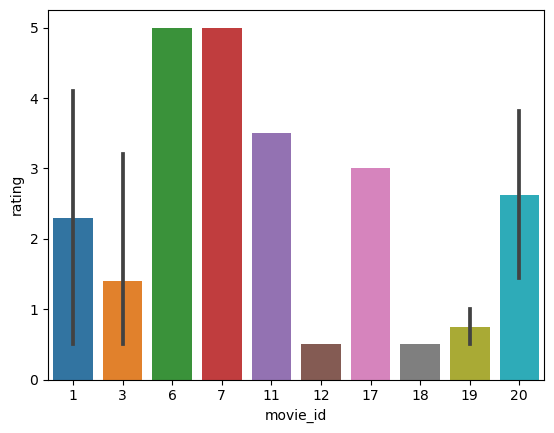

In [33]:
# 영화 점수 분포 시각화
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(y = ratings['rating'], x= ratings['movie_id'])
# object_cnt = ratings['rating'].value_counts()
# for x,y,z in zip(object_cnt.index, object_cnt.values, object_cnt.values/object_cnt.sum()*100):
#     plt.annotate(f"{y}\n({round(z,2)}%)", xy=(x-1,y+70), textcoords="data", ha="center")



In [20]:
# movie_id 기준으로 결합
ratings_movies = pd.merge(ratings, movies, on='movie_id')
ratings_movies.head()

,movie_id,rating,user_id,genre,title
0,1,5.0,1,로맨스,라라랜드
1,1,5.0,4,로맨스,라라랜드
2,1,0.5,1,로맨스,라라랜드
3,1,0.5,1,로맨스,라라랜드
4,1,0.5,1,로맨스,라라랜드


In [21]:
ratings_matrix = ratings_movies.pivot_table('rating', index='user_id', columns='title')
ratings_matrix.fillna(0, inplace=True)
ratings_matrix.head()

title,그린 북,노팅 힐,라라랜드,레옹,매드 맥스 분노의 도로,매트릭스,슬럼독 밀리어네어,아이언맨,존 윅,타이타닉
user_id,,,,,,,,,,
1,0.5,0.0,1.625,0.0,0.5,0.0,0.0,0.5,0.75,2.285714
4,0.0,5.0,5.000,0.0,0.0,5.0,0.0,0.0,0.00,0.000000
8,5.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
9,0.0,0.0,0.000,0.0,0.0,5.0,0.0,0.0,0.00,0.000000
18,0.0,0.0,0.000,3.5,0.0,0.0,0.0,0.5,0.00,0.000000


In [22]:
# 유사도 측정을 위한 Transpose
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head()

user_id,1,4,8,9,18,20
title,,,,,,
그린 북,0.500,0.0,5.0,0.0,0.0,0.0
노팅 힐,0.000,5.0,0.0,0.0,0.0,0.0
라라랜드,1.625,5.0,0.0,0.0,0.0,0.0
레옹,0.000,0.0,0.0,0.0,3.5,0.0
매드 맥스 분노의 도로,0.500,0.0,0.0,0.0,0.0,0.0


In [23]:
#코사인 유사도 측정
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head()

(10, 10)


title,그린 북,노팅 힐,라라랜드,레옹,매드 맥스 분노의 도로,매트릭스,슬럼독 밀리어네어,아이언맨,존 윅,타이타닉
title,,,,,,,,,,
그린 북,1.000000,0.000000,0.030755,0.0,0.099504,0.000000,0.0,0.070360,0.099504,0.041370
노팅 힐,0.000000,1.000000,0.951034,0.0,0.000000,0.707107,0.0,0.000000,0.000000,0.000000
라라랜드,0.030755,0.951034,1.000000,0.0,0.309086,0.672483,0.0,0.218557,0.309086,0.128506
레옹,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.707107,0.000000,0.000000
매드 맥스 분노의 도로,0.099504,0.000000,0.309086,0.0,1.000000,0.000000,0.0,0.707107,1.000000,0.415760


In [24]:
# 추천 영화 DataFrame반환 함수
def find_sim_movie_item(df, title_name, top_n=10):
    title_movie_sim = df[[title_name]].drop(title_name, axis=0)
    return title_movie_sim.sort_values(title_name, ascending=False)[:top_n]

- 라라랜드 -> top10 추천

In [27]:
find_sim_movie_item(item_sim_df, '라라랜드', 10)

title,라라랜드
title,
노팅 힐,0.951034
매트릭스,0.672483
매드 맥스 분노의 도로,0.309086
존 윅,0.309086
아이언맨,0.218557
타이타닉,0.128506
그린 북,0.030755
레옹,0.000000
슬럼독 밀리어네어,0.000000


- 레옹 top10추천

In [28]:
find_sim_movie_item(item_sim_df, '레옹', 10)

title,레옹
title,
아이언맨,0.707107
그린 북,0.000000
노팅 힐,0.000000
라라랜드,0.000000
매드 맥스 분노의 도로,0.000000
매트릭스,0.000000
슬럼독 밀리어네어,0.000000
존 윅,0.000000
타이타닉,0.000000


### CF - based KNN 모델 학습


In [34]:
!pip install surprise

     -------------------------------------- 772.0/772.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-win_amd64.whl size=1083719 sha256=8282d900b3a4c0f133993407c244ab6be4d62811fbff97599eb7600bddb08522
  Stored in directory: c:\users\minsu\appdata\local\pip\cache\wheels\df\e4\a6\7ad72453dd693f420b0c639bedeec34641738d11b55d8d9b84
Successfully built scikit-surprise


In [35]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "movie_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [36]:
from surprise import KNNBasic
algo = KNNBasic(k=3, min_k=1, sim_options={'user_based': True, "name": "cosine"})
algo.fit(trainset)
predictions = algo.test(testset)

from surprise import accuracy
acc = accuracy.rmse(predictions)
acc

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7077


1.7076828622485771

In [37]:
predictions[:5]

[Prediction(uid=18, iid=11, r_ui=3.5, est=2.2142857142857144, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=1, iid=1, r_ui=0.5, est=2.0, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=1, iid=20, r_ui=3.0, est=2.5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=1, iid=20, r_ui=0.5, est=2.5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=9, iid=7, r_ui=5.0, est=2.2142857142857144, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})]

### MF - based (SVD)모델 학습

In [39]:
from surprise import SVD

param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []
import time
# n_factor depth에 따른 RMSE 확인
for n in param_list:
    train_start = time.time()
    algo = SVD(n_factors=n)
    algo.fit(trainset)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end-train_start))
    print(f"RMSE of test dataset in SVD model, n_factors={n}")

    predictions = algo.test(testset)
    rmse_list_by_factors.append(accuracy.mse(predictions))
    ttime_list_by_factors.append(train_end-train_start)
    print("-"*20)
print("searching n_factors is finish.")

training time of model: 0.00 seconds
RMSE of test dataset in SVD model, n_factors=10
MSE: 2.6548
--------------------
training time of model: 0.00 seconds
RMSE of test dataset in SVD model, n_factors=50
MSE: 2.6486
--------------------
training time of model: 0.00 seconds
RMSE of test dataset in SVD model, n_factors=100
MSE: 2.6650
--------------------
training time of model: 0.00 seconds
RMSE of test dataset in SVD model, n_factors=150
MSE: 2.7010
--------------------
training time of model: 0.00 seconds
RMSE of test dataset in SVD model, n_factors=200
MSE: 2.7780
--------------------
searching n_factors is finish.


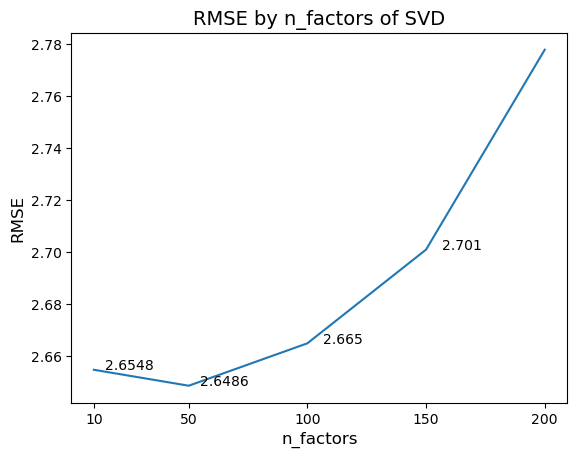

In [40]:
import matplotlib.pyplot as plt
plt.plot(param_list, rmse_list_by_factors)
plt.title("RMSE by n_factors of SVD", fontsize=14)
plt.xticks(param_list)
plt.xlabel("n_factors", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
for x, y in zip(param_list, rmse_list_by_factors):
    plt.annotate(f'{round(y,4)}', xy=(x+15,y), textcoords="data", ha="center")

In [41]:
# n_factor = 50일 때 최소가 됨을 알 수 있다.
algo = SVD(n_factors=50)
algo.fit(trainset)
predictions = algo.test(testset)
acc = accuracy.rmse(predictions)
acc

RMSE: 1.6346


1.6346055225361116

In [44]:
# 예측할 부분 (rating이 없는) 데이터만 추출
test_data = train_data.build_anti_testset()

# test
predictions = algo.test(testset)


predictions = algo.test(test_data)

# test 평가를 위해 시청하지 않은 영화의 예상 점수를 dictionary 형태로 추출
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
    if uid in estimated_unwatched_dict:
        estimated_unwatched_dict[uid].append((iid, predicted_rating))
    else:
        estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

NameError: name 'train_data' is not defined

In [42]:
def get_map_topk(k):
    user_metric = []
    for user in estimated_unwatched_dict:
        estimated_list = estimated_unwatched_dict[user].copy()
        estimated_list.sort(key=lambda tup: tup[1], reverse=True)
        try:
            top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
            actual_watch_list = user_watch_dict_list_test[user_watch_dict_list_test.index==user].values.tolist()[0]
            user_metric.append((user, top_k_prefer_list, actual_watch_list))
        except:
            pass

    # MAP: 유저들의 precision 평균으로 구함
    precision_list = []
    for user in user_metric:
        predictive_values = user[1]
        actual_values = set(user[2])
        tp = [pv for pv in predictive_values if pv in actual_values]
        precision = len(tp) / len(predictive_values)
        precision_list.append(precision)
    return sum(precision_list) / len(precision_list)

In [43]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:
    map_list.append(get_map_topk(k))

plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

NameError: name 'estimated_unwatched_dict' is not defined